### Binary classification about company bankruptcys in Taiwan
(not very well distributed)

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from bpitnorm.modules.BatchPitNormalization import BatchPitNorm1d

device = "cuda" if torch.cuda.is_available() else "cpu"

data = np.genfromtxt("Data/taiwaneseBankruptcyPred.csv", delimiter=",", skip_header=1)
data = data[~(np.isnan(data)).any(axis=1)]
data = data[~(np.isinf(data)).any(axis=1)]
print("Number of features: ", data.shape[1])
print("Number of datapoints: ", data.shape[0])

def data_split(data):
  X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(data[:, 1:], data[:, 0], test_size=0.2)
  y_train_raw = y_train_raw.reshape(-1, 1)
  y_test_raw = y_test_raw.reshape(-1, 1)

  scaler1 = StandardScaler()
  scaler_x = scaler1.fit(X_train_raw)
  X_train = scaler_x.transform(X_train_raw)
  X_test = scaler_x.transform(X_test_raw)

  scaler2 = StandardScaler()
  scaler_y = scaler2.fit(y_train_raw)

  X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
  y_train = torch.tensor(y_train_raw, dtype=torch.float32, device=device).reshape(-1, 1)
  X_test = torch.tensor(X_test, dtype=torch.float32).to(device=device)
  y_test = torch.tensor(y_test_raw, dtype=torch.float32, device=device).reshape(-1, 1)
  return X_train, y_train, X_test, y_test, scaler_y

Number of features:  96
Number of datapoints:  6819


In [2]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score

def train_model(model, loops):
    model.to(device=device)
    acc_lst = np.zeros(loops)
    f1_lst = np.zeros(loops)

    for i in range(loops):
        X_train, y_train, X_test, y_test, scaler_y = data_split(data)
        loss_fn = nn.BCEWithLogitsLoss().to(device=device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        train_loader = DataLoader(list(zip(X_train, y_train)), batch_size=150, shuffle=True)
        n_epochs = 30
        for epoch in range(n_epochs):
            model.train()
            for x_batch, y_batch in train_loader:
                x_batch, y_batch = x_batch.to(device=device), y_batch.to(device=device)
                y_pred = model(x_batch)
                loss = loss_fn(y_pred, y_batch)
                loss.backward(retain_graph=True)
                optimizer.step()
                optimizer.zero_grad()
        model.eval()
        y_pred = model(X_test)
        y_pred_prob = torch.sigmoid(y_pred)
        y_pred_binary = (y_pred_prob > 0.5).float().cpu().detach()
        acc = accuracy_score(y_test.cpu(), y_pred_binary)
        acc_lst[i] = float(acc)
        f1 = f1_score(y_test.cpu(), y_pred_binary)
        f1_lst[i] = float(f1)
        print("Accuracy:", float(acc))
        print("F1-score:", float(f1))
    return acc_lst, f1_lst

Accuracy: 0.9655425219941349
F1-score: 0.3380281690140845
Accuracy: 0.9714076246334311
F1-score: 0.5517241379310345
Accuracy: 0.9809384164222874
F1-score: 0.6388888888888888
Accuracy: 0.9838709677419355
F1-score: 0.6451612903225806
Accuracy: 0.9941348973607038
F1-score: 0.9245283018867925


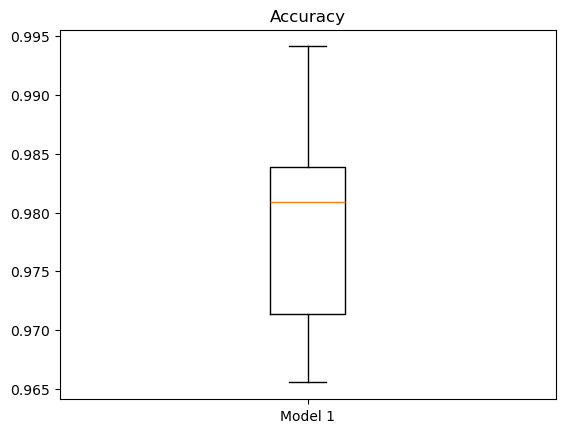

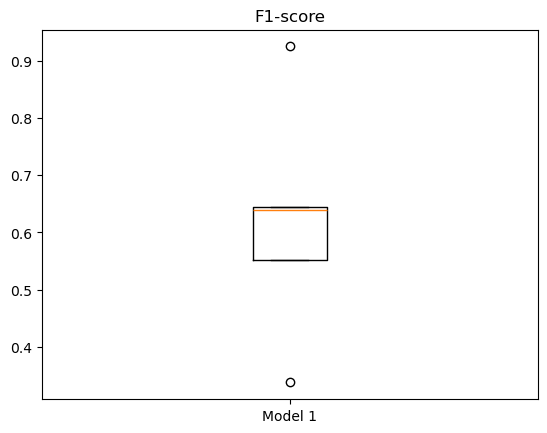

In [3]:
model1 = nn.Sequential(
    nn.Linear(data.shape[1]-1, 100),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, 10),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(10, 1))
model1.to(device=device)

acc1, f1_1 = train_model(model1, 5)
plt.boxplot(acc1, labels=["Model 1"])
plt.title("Accuracy")
plt.show()

plt.boxplot(f1_1, labels=["Model 1"])
plt.title("F1-score")
plt.show()

Accuracy: 0.9648093841642229
F1-score: 0.2727272727272727
Accuracy: 0.9809384164222874
F1-score: 0.6285714285714286
Accuracy: 0.9758064516129032
F1-score: 0.6024096385542169
Accuracy: 0.9846041055718475
F1-score: 0.7961165048543689
Accuracy: 0.9882697947214076
F1-score: 0.7894736842105263


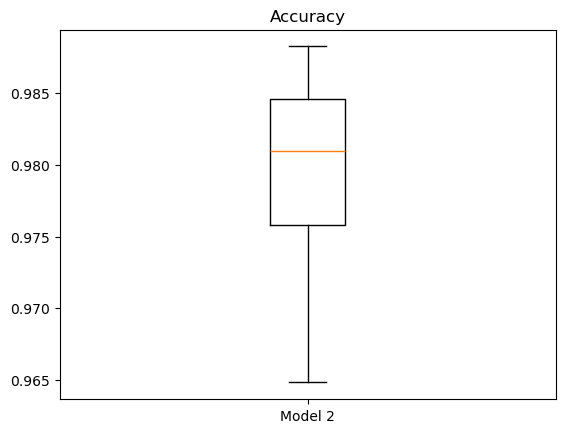

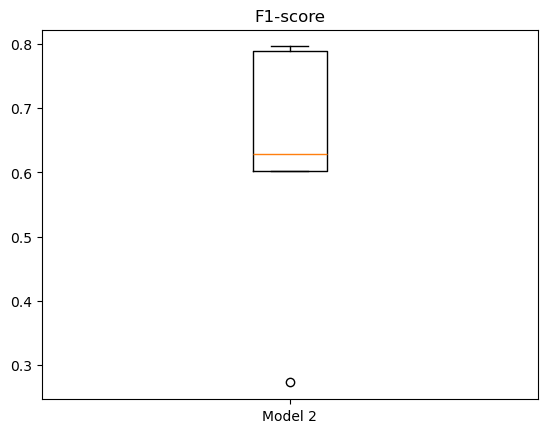

In [4]:
model2 = nn.Sequential(
    nn.Linear(data.shape[1]-1, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, 10),
    nn.ReLU(),
    nn.Linear(10, 1))
model2.to(device=device)

acc2, f1_2 = train_model(model2, 5)
plt.boxplot(acc2, labels=["Model 2"])
plt.title("Accuracy")
plt.show()

plt.boxplot(f1_2, labels=["Model 2"])
plt.title("F1-score")
plt.show()

Accuracy: 0.9589442815249267
F1-score: 0.36363636363636365
Accuracy: 0.9802052785923754
F1-score: 0.6086956521739131
Accuracy: 0.9860703812316716
F1-score: 0.759493670886076
Accuracy: 0.9912023460410557
F1-score: 0.8636363636363636
Accuracy: 0.9963343108504399
F1-score: 0.9484536082474226


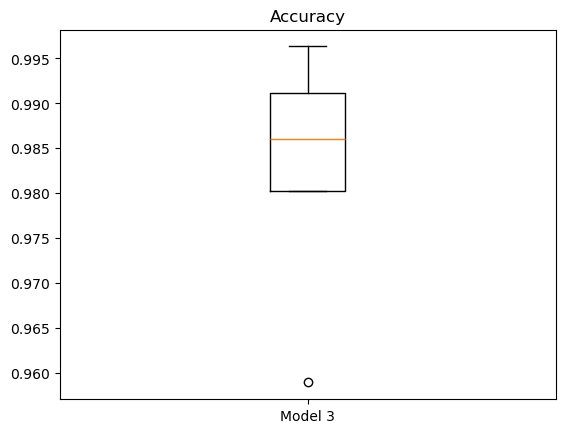

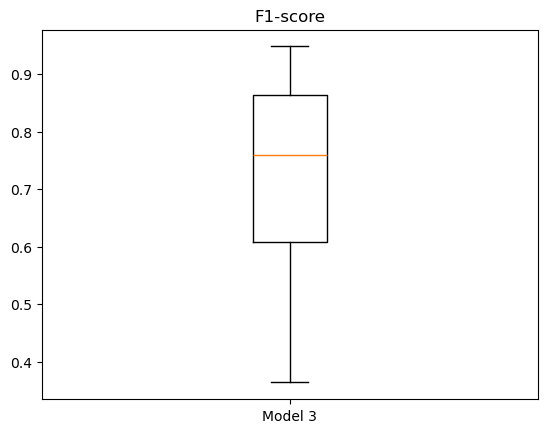

In [5]:
model3 = nn.Sequential(
    nn.Linear(data.shape[1]-1, 100),
    BatchPitNorm1d(num_features=100, num_pit_samples=200, take_num_samples_when_full=0, dev=device),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, 10),
    nn.ReLU(),
    nn.Linear(10, 1))
model3.to(device=device)

acc3, f1_3 = train_model(model3, 5)
plt.boxplot(acc3, labels=["Model 3"])
plt.title("Accuracy")
plt.show()

plt.boxplot(f1_3, labels=["Model 3"])
plt.title("F1-score")
plt.show()

Accuracy: 0.9479472140762464
F1-score: 0.3364485981308411
Accuracy: 0.9589442815249267
F1-score: 0.0
Accuracy: 0.9655425219941349
F1-score: 0.0784313725490196
Accuracy: 0.9721407624633431
F1-score: 0.0
Accuracy: 0.9626099706744868
F1-score: 0.07272727272727272


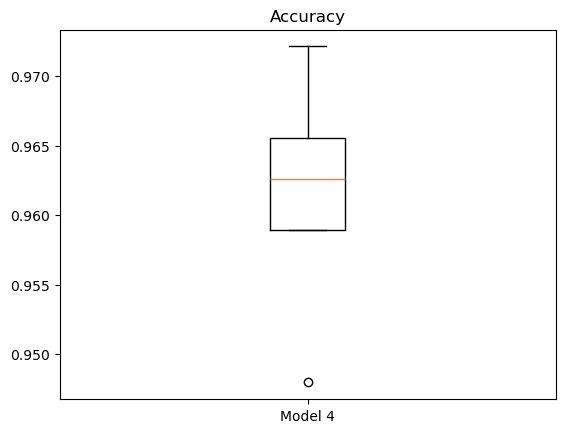

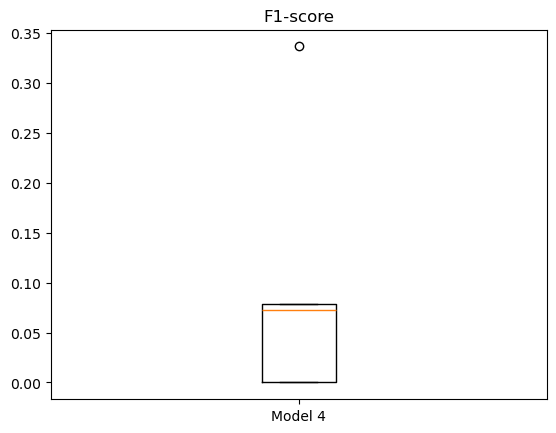

In [7]:
model4 = nn.Sequential(
    nn.Linear(data.shape[1]-1, 100),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, 10),
    BatchPitNorm1d(num_features=10, num_pit_samples=200, take_num_samples_when_full=0, dev=device),
    nn.ReLU(),
    nn.Linear(10, 1))
model4.to(device=device)

acc4, f1_4 = train_model(model4, 5)
plt.boxplot(acc4, labels=["Model 4"])
plt.title("Accuracy")
plt.show()

plt.boxplot(f1_4, labels=["Model 4"])
plt.title("F1-score")
plt.show()

In [8]:
model5 = nn.Sequential(
    nn.Linear(data.shape[1]-1, 100),
    BatchPitNorm1d(num_features=100, num_pit_samples=200, take_num_samples_when_full=0, dev=device),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.BatchNorm1d(50),
    nn.Linear(50, 10),
    nn.ReLU(),
    nn.Linear(10, 1))
model5.to(device=device)

acc5, f1_5 = train_model(model5, 5)
plt.boxplot(acc5, labels=["Model 5"])
plt.title("Accuracy")
plt.show()

plt.boxplot(f1_5, labels=["Model 5"])
plt.title("F1-score")
plt.show()

Accuracy: 0.9560117302052786
F1-score: 0.16666666666666666


In [ ]:
model6 = nn.Sequential(
    nn.Linear(data.shape[1]-1, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.ReLU(),
    BatchPitNorm1d(num_features=50, num_pit_samples=200, take_num_samples_when_full=0, dev=device),
    nn.Linear(50, 10),
    nn.ReLU(),
    nn.Linear(10, 1))
model6.to(device=device)

acc6, f1_6 = train_model(model6, 5)
plt.boxplot(acc6, labels=["Model 6"])
plt.title("Accuracy")
plt.show()

plt.boxplot(f1_6, labels=["Model 6"])
plt.title("F1-score")
plt.show()

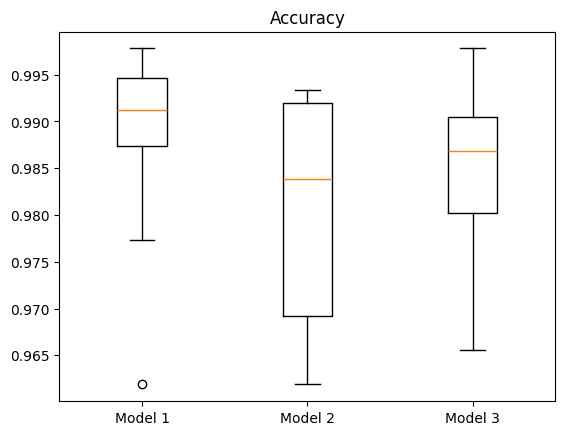

In [ ]:
plt.boxplot([acc1, acc2, acc3, acc4, acc5, acc6], labels=["Model 1", "Model 2", "Model 3", "Model 4", "Model 5", "Model 6"])
plt.title("Accuracy")
plt.show()

plt.boxplot([f1_1, f1_2, f1_3, f1_4, f1_5, f1_6], labels=["Model 1", "Model 2", "Model 3", "Model 4", "Model 5", "Model 6"])
plt.title("F1-score")
plt.show()

Model 1: Without any batch layer 

Model 2: With ordinary batch normalization layer.

Model 3: With batch pit normalization layer.

The models accuracys is very close to eachother. The one without any batch layer seems to be the best, around $99\%$ accuracy.